# CUPS DETECTION PROJECT

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
### rename files script
# import os
# path = 'CUPS_DATABASE/test/proper/'
# files = os.listdir(path)

# for index, file in enumerate(files):
#     os.rename(os.path.join(path, file), os.path.join(path,'cup'+str(index)+'.jpg'))


## LOAD IMAGE

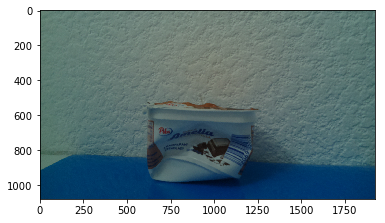

In [251]:
cup1 = cv2.imread('CUPS_DATABASE/train/curved/cup1.jpg')
cup1 = cv2.cvtColor(cup1, cv2.COLOR_BGR2RGB)
plt.imshow(cup1)

## OPENCV IMAGE PROCESSING

In [252]:
found, corners = cv2.findChessboardCorners(cup1,(7,7))

In [1]:
# cv2.drawChessboardCorners(cup1, (7,7), corners, found)
# plt.imshow(cup1)
# cv2.find

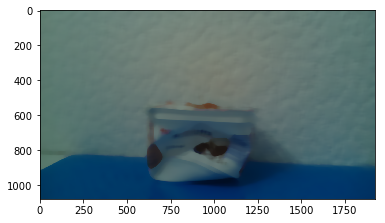

In [254]:
cup1_blur = cv2.medianBlur(cup1, 35)
plt.imshow(cup1_blur)

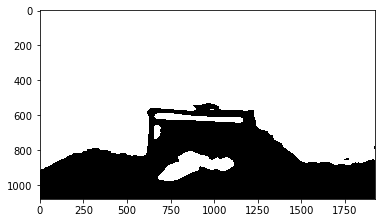

In [255]:
cup1_gray = cv2.cvtColor(cup1_blur, cv2.COLOR_RGB2GRAY)
ret, th1 = cv2.threshold(cup1_gray, 90, 125, cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(cup1_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 5)
blended = cv2.addWeighted(src1=th1, alpha=0.6, src2=th2, beta=0.4, gamma=0)

plt.imshow(th1, cmap='gray')

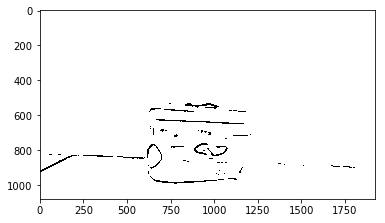

In [256]:
ret, cup1_bin = cv2.threshold(blended, 101,255,cv2.THRESH_BINARY)
plt.imshow(cup1_bin, cmap='gray')

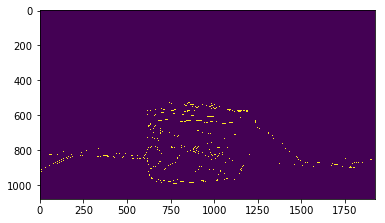

In [257]:
edges = cv2.Canny(blended, 10, 20)
plt.imshow(edges)

In [258]:
median = np.median(blended)
median

177.0

In [259]:
lower = int(max(0, 0.7*median))
higher = int(min(255, 1.3*median))
# lower = 77
# higher = 143

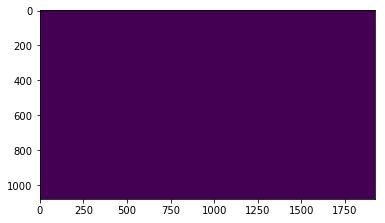

In [260]:
blurred_img = cv2.blur(cup1,ksize=(3,3))
edges = cv2.Canny(blurred_img, lower, higher+50)
plt.imshow(edges)

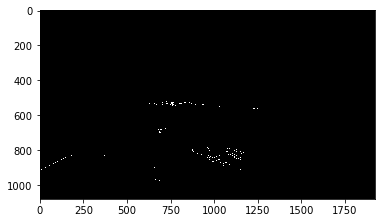

In [261]:
edges = cv2.Canny(cup1, 140, 200)
plt.imshow(edges,cmap='gray')

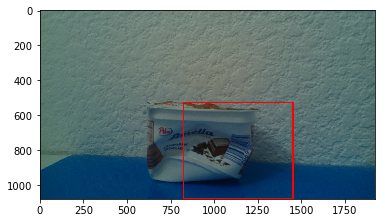

In [262]:
cup1_rec = cup1.copy()
cv2.rectangle(cup1_rec,(820,530),(1450,1080),color=(255,0,0),thickness=5)
plt.imshow(cup1_rec)

## KERAS DATA PREPROCESSING 

In [123]:
from keras.preprocessing.image import ImageDataGenerator

In [124]:
# image preprocessing
image_gen = ImageDataGenerator(rotation_range = 10, # set possible rotation of the image
                              width_shift_range = 0.2, # set possible resize scale of the image [width]
                              #height_shift_range = 0.1, # set possible resize scale of the image [height]
                              rescale = 1/255, # set values of the pixels from range [0.0 , 1.0]
                              shear_range = 0.2, # % of cutting image part 
                              #zoom_range = 0.2, # % of possible zoom image
                              #brightness_range= [0, 100],
                               horizontal_flip = True, # enable image flip horizontal
                               fill_mode = 'nearest'# fill missing pixels [especially in stretch image]
                              )

# image_gen_new = ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     zca_epsilon=1e-06,
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0,
#     brightness_range=None,
#     shear_range=0.0,
#     zoom_range=0.0,
#     channel_shift_range=0.0,
#     fill_mode="nearest",
#     cval=0.0,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
#     preprocessing_function=None,
#     data_format=None,
#     validation_split=0.0,
#     dtype=None,
# )


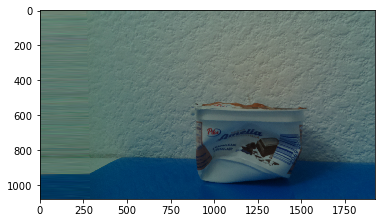

In [126]:
plt.imshow(image_gen.random_transform(cup1))

In [137]:
image_gen.flow_from_directory('CUPS_DATABASE/train/')

Found 826 images belonging to 4 classes.


## CREATING A MODEL

In [227]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

In [228]:
input_shape=(300,300,3)

In [229]:
model = Sequential()

# default 3 convolucional layers - can add more / change number of filters 
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(300,300,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(300,300,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(300,300,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5)) # it reduce overfitting, when there's to many number of neurons

model.add(Dense(4, activation='sigmoid')) # softmax

model.compile(loss='binary_crossentropy', # mse
             optimizer='adam',
             metrics=['accuracy'])

In [230]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 78400)             0         
__________

In [231]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('CUPS_DATABASE/train/',
                                               target_size=input_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 826 images belonging to 4 classes.


In [232]:
batch_size = 16

test_image_gen = image_gen.flow_from_directory('CUPS_DATABASE/test/', 
                                               target_size = input_shape[:2],
                                               batch_size = batch_size,
                                               class_mode='categorical')

Found 231 images belonging to 4 classes.


In [233]:
train_image_gen.class_indices

{'curved': 0, 'open_lid': 1, 'proper': 2, 'unclean': 3}

In [234]:
results = model.fit_generator(train_image_gen, epochs=10, steps_per_epoch=150,
                             validation_data=test_image_gen, validation_steps=12)

Epoch 1/10
150/150 [==============================] - 317s 2s/step - loss: 0.5805 - acc: 0.7448 - val_loss: 0.5449 - val_acc: 0.7576
Epoch 2/10
150/150 [==============================] - 307s 2s/step - loss: 0.4487 - acc: 0.7906 - val_loss: 0.4663 - val_acc: 0.7695
Epoch 3/10
150/150 [==============================] - 303s 2s/step - loss: 0.3306 - acc: 0.8397 - val_loss: 0.4593 - val_acc: 0.7868
Epoch 4/10
150/150 [==============================] - 306s 2s/step - loss: 0.2775 - acc: 0.8829 - val_loss: 0.5405 - val_acc: 0.7608
Epoch 5/10
150/150 [==============================] - 301s 2s/step - loss: 0.2156 - acc: 0.9079 - val_loss: 0.7901 - val_acc: 0.7965
Epoch 6/10
150/150 [==============================] - 305s 2s/step - loss: 0.1871 - acc: 0.9196 - val_loss: 1.6991 - val_acc: 0.6861
Epoch 7/10
150/150 [==============================] - 303s 2s/step - loss: 0.1523 - acc: 0.9404 - val_loss: 0.8246 - val_acc: 0.7641
Epoch 8/10
150/150 [==============================] - 305s 2s/step - 

In [235]:
results.history['acc']

[0.7447654941373534,
 0.7906144780141336,
 0.8394206549118388,
 0.8830611389785555,
 0.9078282826275937,
 0.9202261306033462,
 0.9400252525754248,
 0.9442001674542675,
 0.9589630562552477,
 0.959277917666159]

In [282]:
model.metrics_names

['loss', 'acc']

In [284]:
#model.evaluate(test_image_gen)

In [236]:
model.save('cupModel_v1.h5')

## SINGLE OBJECT PREDICTION

In [3]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

Using TensorFlow backend.


In [4]:
new_model = load_model('cupModel_v1.h5')

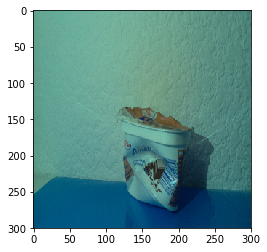

In [6]:
cup_file = 'CUPS_DATABASE/test/curved/cup20.jpg'
cup_img = image.load_img(cup_file,target_size=(300,300))
plt.imshow(cup_img)

In [7]:
cup_img = image.img_to_array(cup_img)
cup_img = np.expand_dims(cup_img, axis=0)
cup_scaled = cup_img / 255
pred1 = new_model.predict_classes(cup_scaled)

if pred1 == 0:
    result = 'CURVED'
elif pred1 == 1:
    result = 'OPEN LID'
elif pred1 == 2:
    result = 'PROPER'
elif pred1 == 3:
    result = 'UNCLEAN'

print(result)

CURVED


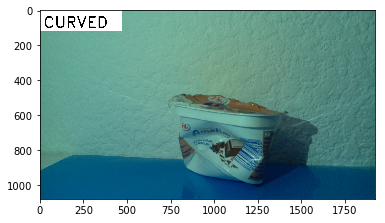

In [8]:
cup_detected = cv2.imread(cup_file)
cup_detected = cv2.cvtColor(cup_detected, cv2.COLOR_BGR2RGB)
font = font = cv2.FONT_HERSHEY_DUPLEX
cv2.rectangle(cup_detected, (0,0),(470,120),[255,255,255], -1)
cv2.putText(cup_detected, result, (20, 100), font, 3, (0,0,0), 3, cv2.LINE_AA)
plt.imshow(cup_detected)

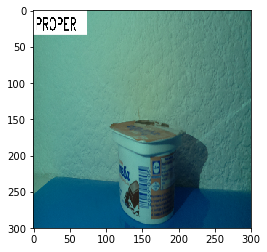

In [304]:
output = cv2.resize(cup_detected, (300, 300))
plt.imshow(output)